# 【第２回目　課題２】PyTorchを使った深層学習 (2): 畳み込み編

課題１に引き続いてPytorchのSequential modelを用いて，前回の課題２のフィルタ学習を行ってみます．
エッジ検出のフィルタを3層の畳み込みネットワークで学習してみます．

入出力は画像ですが，基本的に出力回帰問題ですので，課題１と同じで，最小２乗誤差を用いて学習します．

In [157]:
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 必要があれば，GPU IDを指定します．
# IEDは 8GPUなので必ず指定してください．
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "7"

次に画像の読み込みに必要なPIL, 表示に必要なmatplotlibなどのモジュールを読み込みます．

In [158]:
from skimage import feature,filters
from PIL import Image
import os
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

画像を読み込んで，エッジ画像を生成して，学習データを作ります．Canny法でエッジ抽出します．
use_edge=Falseとすれば，目標画像を濃淡画像にするので，濃淡化フィルタの学習になります．

なお，PyTorchでは，テンソルは Batch, Channel, Height, Width の順番に表現しますので，
読み込んだ画像を
img=img.transpose(2,0,1) で HWC から CHW へ変換して，さらに batchの軸を
gt=gt[np.newaxis, ...]
で追加します．

(3, 240, 320) (1, 240, 320)


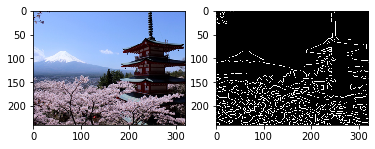

In [159]:
img_org = Image.open('landscape.jpg').resize((320,240))
img = np.array(img_org, dtype=np.uint8)
grey = np.array(img_org.convert('L'), dtype=np.uint8)
edge = feature.canny(grey,sigma=2)  # Canny でエッジ抽出
# edge = filters.sobel(grey) # Sobel でエッジ抽出
edge = edge * 255

# エッジ検出フィルタ，グレースケール化フィルタの切り替え
use_edge=True  # Falseだとグレースケール化フィルタの学習
if use_edge:
    gt=edge
else:
    gt=grey

plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(gt,cmap="gray")

img=img.transpose(2,0,1) # HWC から CHW へ変換
gt=gt[np.newaxis, ...]

print(img.shape,gt.shape)

読み込んだ画像と変換した画像を，numpy形式に変換します．
(c,h,w) c:チャネル, h:高さ, w:幅　のサイズの3次元配列にします．
PyTorch の標準の形式は，(c,h,w) です.

ここでは画像は320x240で，入力はカラーなので，
input: (3,240,320)
output: (1,240,320)
の大きさです．

In [160]:
# 画素値が [-1,1) の範囲の値になるように変換
# Keras は (h,w,c)が標準ですので，前回の
#input  = (np.asarray(img, dtype=np.float32).transpose(2,0,1)-128)/128.0 の transposeが不要になります．
input  = (np.asarray(img, dtype=np.float32)-127.5)/127.5
output = (np.asarray(gt, dtype=np.float32)-127.5)/127.5

# Keras では，convolution へ与えるデータは最初にbatchの次元を追加して４次元テンソルで表現します．
# 画像１枚での学習なので，batch は 1 です．
# さらに，torch形式のtensorへ変換します．
input = torch.from_numpy(input[np.newaxis, ...])     # (3, 240,320) -> (1,3, 240,320)
output = torch.from_numpy(output[np.newaxis, ...])   # (1, 240,320) -> (1,1, 240,320)

In [34]:
# 学習途中のlossなどのグラフ表示を行う ShowGraphを定義
# グラフ表示で必要なので，コンストラクタで，model, 最大エポック数 を受け取っておく．
# model は，学習途中のパラメータを用いて， y=f(x)を描画するのに必要．
class ShowGraph:
    def __init__(self,model,max_epoch,test_img):
        # 表示エリアの設定
        self.fig=plt.figure(figsize=(8,4))
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0, 1])
        self.fig1.set_title('loss')
        self.fig1.set_ylabel('loss')
        self.fig1.set_xlabel('epoch')
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([-8,8,-10,30])
        self.model=model
        self.max_epoch=max_epoch
        self.test_img=test_img
        self.start=time.time()
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses=[]
        self.n_epoch=[]
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, loss, out):
        self.n_epoch.append(epoch)
        self.losses.append(loss)
        self.loss=loss
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.losses,"r") 
        self.out=(out.squeeze()+1.0)*127.5  # 表示するときは，[0.255]に戻します．
        #print out.shape, self.out.shape
        self.fig2.imshow(self.out.detach().numpy(),cmap="gray",vmin=0,vmax=255)
        display.display(self.fig)
        if epoch<self.max_epoch-1:
            self.fig2.cla()

    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val loss値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        print("loss:",self.loss)
        print('Time: ',time.time()-self.start)

畳み込み層を3つ用意します．
3x3x20 -> 3x3x20 -> 3x3x1 です．
1,2層目はReLU付きです．

<a href="https://pytorch.org/docs/stable/nn.html#conv2d">Conv2d</a>を利用します．PyTorchでは，Conv2dのdは小文字ですので，注意してください．

特徴マップのサイズを変化させたくない場合は，3x3のConvの場合，padding=1とします．

In [50]:
#c1=Conv(3,3,3,10,pad=1)
#c2=Conv(10,3,3,10,pad=1)
#c3=Conv(10,3,3,1,pad=1,relu=0)

model = nn.Sequential(
    nn.Conv2d(3, 20, 3, padding=1),
    #nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 20, 3, padding=1),
    #nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 1, 3, padding=1),
)

In [51]:
print(model)

Sequential(
  (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(20, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


CPUからGPUにモデルと学習データを転送します．
これを忘れるとCPUで計算するので，時間かかってしまします．

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
input = input.to(device)
output=output.to(device)

学習ループです．
学習率lr = 0.01
エポック数200とします．
課題１と同様に，MSE loss(二乗誤差), SGDを利用します．momentum=0.9とします．

loss: 0.23875916004180908
Time:  16.97255039215088


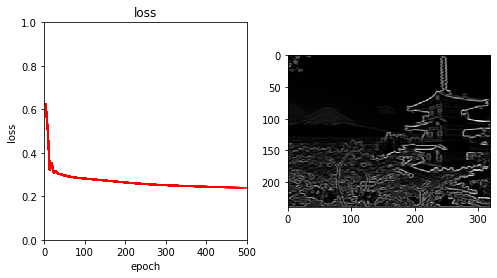

In [53]:
num_epoch=500
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)
#optimizer = optim.Adam(model.parameters())
#optimizer = optim.RMSprop(model.parameters())

show_graph=ShowGraph(model,num_epoch,input)
show_graph.on_train_begin();

model.train()

for t in range(num_epoch):
    out = model(input)

    # Compute and print loss.
    loss = loss_fn(out, output)
    if t % 5 == 4:
        show_graph.on_epoch_end(t,loss.item(),out.cpu()) # out.cpu()で結果表示のためにGPUからCPUに戻します．

    # backwardする前に，必ず一度勾配をクリアする．デフォルトでは勾配は足し算される．
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph

### 課題2
サンプル画像を各自，自分で用意した画像に入れ替えて，以下の小問の(1)-(3)を解答すること．

1. OptimizerをRMSprop, Adamに変更して，モーメンタムSDGとの違いを観察せよ．
1. (1)で最もlossが小さくなったoptimizerを利用して，Batch Normalization Layer を入れた場合と入れない場合で，結果を比較せよ．
1. 複数の画像に対応させてみよ．学習画像を2枚, 3枚とするとどうなるか？

学習したモデルで画像を変換（エッジ抽出）してみます．

torch.Size([1, 3, 240, 320]) (1, 1, 240, 320)
0.8055527 -1.3171675
0.8055527 -1.0


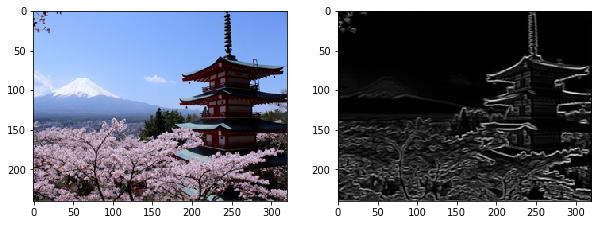

In [39]:
img=np.array(Image.open('landscape.jpg').resize((320,240)), dtype=np.float32)
img
img2=img[np.newaxis,...].transpose(0,3,1,2)
img2=torch.from_numpy(img2/127.5-1.0)
model.eval() # batch normalization, dropoutがある時は，trainとevalの時で挙動が異なるので，モードを切り替えます．

with torch.no_grad():
    out=model(img2.to(device)).cpu().detach().numpy()
print(img2.shape,out.shape)
print(np.max(out),np.min(out))
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
print(np.max(out),np.min(out))
out=(out+1.0)*127.5                 # 表示するときは，[0..255]に戻します．
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img/255)  # 値が floatの場合は 値域が [0,1] になるようにします．
plt.subplot(122)
plt.imshow(np.squeeze(out),cmap="gray",vmin=0,vmax=255)
plt.show()

loss: 0.2167549878358841
Time:  17.25212860107422


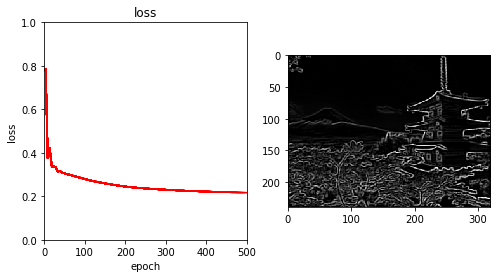

In [60]:
model = nn.Sequential(
    nn.Conv2d(3, 20, 3, padding=1),
    #nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 20, 3, padding=1),
    #nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 1, 3, padding=1),
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
input = input.to(device)
output=output.to(device)


num_epoch=500
loss_fn = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)
optimizer = optim.Adam(model.parameters())
#optimizer = optim.RMSprop(model.parameters())

show_graph=ShowGraph(model,num_epoch,input)
show_graph.on_train_begin();

model.train()

for t in range(num_epoch):
    out = model(input)

    # Compute and print loss.
    loss = loss_fn(out, output)
    if t % 5 == 4:
        show_graph.on_epoch_end(t,loss.item(),out.cpu()) # out.cpu()で結果表示のためにGPUからCPUに戻します．

    # backwardする前に，必ず一度勾配をクリアする．デフォルトでは勾配は足し算される．
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph

loss: 0.29536888003349304
Time:  16.926310539245605


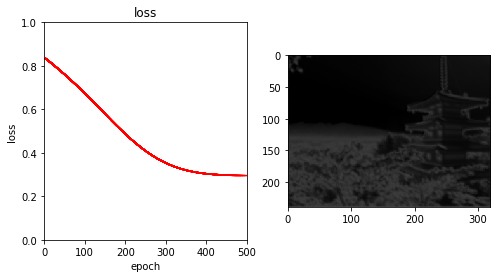

In [165]:
del model

model = nn.Sequential(
    nn.Conv2d(3, 20, 3, padding=1),
    #nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 20, 3, padding=1),
    #nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 1, 3, padding=1),
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
input = input.to(device)
output=output.to(device)

num_epoch=500
loss_fn = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)
#optimizer = optim.Adam(model.parameters())
optimizer = optim.RMSprop(model.parameters())

show_graph=ShowGraph(model,num_epoch,input)
show_graph.on_train_begin();

model.train()

for t in range(num_epoch):
    out = model(input)

    # Compute and print loss.
    loss = loss_fn(out, output)
    if t % 5 == 4:
        show_graph.on_epoch_end(t,loss.item(),out.cpu()) # out.cpu()で結果表示のためにGPUからCPUに戻します．

    # backwardする前に，必ず一度勾配をクリアする．デフォルトでは勾配は足し算される．
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph

# 2.

loss: 0.19728635251522064
Time:  18.251256465911865


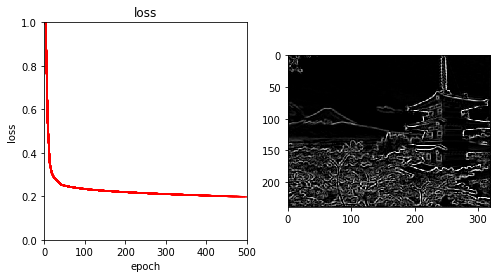

In [164]:
del model

model = nn.Sequential(
    nn.Conv2d(3, 20, 3, padding=1),
    nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 20, 3, padding=1),
    nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 1, 3, padding=1),
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
input = input.to(device)
output=output.to(device)

num_epoch=500
loss_fn = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)
optimizer = optim.Adam(model.parameters())
#optimizer = optim.RMSprop(model.parameters())

show_graph=ShowGraph(model,num_epoch,input)
show_graph.on_train_begin();

model.train()

for t in range(num_epoch):
    out = model(input)

    # Compute and print loss.
    loss = loss_fn(out, output)
    if t % 5 == 4:
        show_graph.on_epoch_end(t,loss.item(),out.cpu()) # out.cpu()で結果表示のためにGPUからCPUに戻します．

    # backwardする前に，必ず一度勾配をクリアする．デフォルトでは勾配は足し算される．
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph

# 3.

(3, 240, 320) (240, 320)


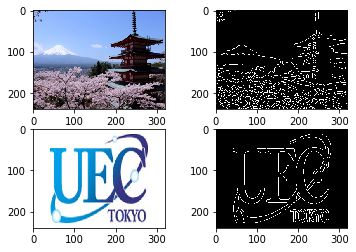

In [166]:
img_org = Image.open('landscape.jpg').resize((320,240))
img = np.array(img_org, dtype=np.uint8)
img_org2 = Image.open('uec_mark.jpg').resize((320,240))
img2 = np.array(img_org2, dtype=np.uint8)

grey = np.array(img_org.convert('L'), dtype=np.uint8)
grey2 = np.array(img_org2.convert('L'), dtype=np.uint8)
edge = feature.canny(grey,sigma=2)  # Canny でエッジ抽出
edge2 = feature.canny(grey2,sigma=2)  # Canny でエッジ抽出
# edge = filters.sobel(grey) # Sobel でエッジ抽出
edge = edge * 255
edge2 = edge2 * 255

# エッジ検出フィルタ，グレースケール化フィルタの切り替え
use_edge=True  # Falseだとグレースケール化フィルタの学習
if use_edge:
    gt = edge
    gt2 = edge2
else:
    gt=grey
    gt2 = grey2

plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
plt.imshow(gt,cmap="gray")

plt.subplot(223)
plt.imshow(img2)
plt.subplot(224)
plt.imshow(gt2,cmap="gray")

img=img.transpose(2,0,1) # HWC から CHW へ変換
img2=img2.transpose(2,0,1)
gt=gt[np.newaxis, ...]
gt2=gt2[np.newaxis, ...]

print(img2.shape,edge.shape)


In [167]:
# 画素値が [-1,1) の範囲の値になるように変換
# Keras は (h,w,c)が標準ですので，前回の
#input  = (np.asarray(img, dtype=np.float32).transpose(2,0,1)-128)/128.0 の transposeが不要になります．
#img=np.array(Image.open('landscape.jpg').resize((320,240)), dtype=np.float32)

#img2 = np.array(Image.open('uec_mark.jpg').resize((320,240)), dtype=np.float32)

input  = (np.asarray(img, dtype=np.float32)-127.5)/127.5
input2 = (np.asarray(img2, dtype=np.float32)-127.5)/127.5

output = (np.asarray(gt, dtype=np.float32)-127.5)/127.5
output2 = (np.asarray(gt2, dtype=np.float32)-127.5)/127.5
print(output2.shape)
# Keras では，convolution へ与えるデータは最初にbatchの次元を追加して４次元テンソルで表現します．
# 画像１枚での学習なので，batch は 1 です．
# さらに，torch形式のtensorへ変換します．
input = torch.from_numpy(input)     # (3, 240,320) -> (1,3, 240,320)
input2 = torch.from_numpy(input2)     # (3, 240,320) -> (1,3, 240,320)
input = torch.stack((input, input2))

output = torch.from_numpy(output)
output2 = torch.from_numpy(output2)
output = torch.stack((output, output2))
#output2.shape

(1, 240, 320)


In [168]:
print(input.shape)
print(output.shape)

torch.Size([2, 3, 240, 320])
torch.Size([2, 1, 240, 320])


loss: 0.13212431967258453
Time:  19.243167400360107


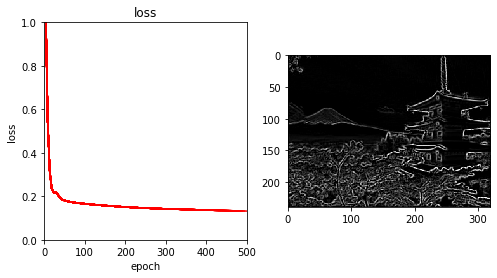

In [169]:
del model
model = nn.Sequential(
    nn.Conv2d(3, 20, 3, padding=1),
    nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 20, 3, padding=1),
    nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 1, 3, padding=1),
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
input = input.to(device)
output=output.to(device)

num_epoch=500
loss_fn = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)
optimizer = optim.Adam(model.parameters())
#optimizer = optim.RMSprop(model.parameters())

show_graph=ShowGraph(model,num_epoch,input)
show_graph.on_train_begin();

model.train()

for t in range(num_epoch):
    out = model(input)

    # Compute and print loss.
    loss = loss_fn(out, output)
    if t % 5 == 4:
        show_graph.on_epoch_end(t,loss.item(),out.cpu()[0]) # out.cpu()で結果表示のためにGPUからCPUに戻します．
        #show_graph.on_epoch_end(t,loss.item(),out.cpu()[1]) # out.cpu()で結果表示のためにGPUからCPUに戻します．

    # backwardする前に，必ず一度勾配をクリアする．デフォルトでは勾配は足し算される．
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph

In [146]:
model.eval()
out = model(input)


In [147]:
out.shape

torch.Size([2, 1, 240, 320])

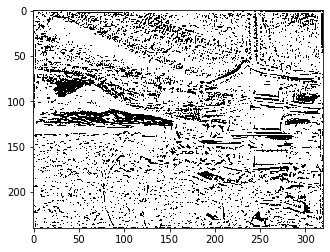

In [154]:
out=(out.squeeze()+1.0)*127.5  # 表示するときは，[0.255]に戻します．
        #print out.shape, self.out.shape
        #self.fig2.imshow(self.out.detach().numpy(),cmap="gray",vmin=0,vmax=255)
        
plt.imshow(out.cpu().detach().numpy()[0], cmap="gray",vmin=0,vmax=255)

In [143]:
out.shape

torch.Size([2, 240, 320])

# 1.
Adamが一番迅速にロスを下げると観察した。最終ロスも三つの中の一番低い値を得られた。

# 2.
BatchNormを入れたことで、最終ロスが21.6から18.8に下がったと観察した

# 3.
学習データが増えたので、最終ロスが0.12にさらに下がったと観察した

